In [1]:
from sklearn.externals.six.moves import zip

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
## 创建模拟数据
X, y = make_gaussian_quantiles(n_samples=13000, n_features=10, 
                               n_classes=3, random_state=1)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

In [4]:
## 构建模型并训练
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1,
    algorithm='SAMME')

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=600, random_state=None)

In [7]:
## 模型效果值获取
real_test_errors = []
discrete_test_errors = []

## 将每构建一个弱分类器就计算出该弱的错误率值添加到list集合中
for real_test_predict, discrete_train_predict in zip(bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(1 - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(1 - accuracy_score(discrete_train_predict, y_test))

#获取弱分类器数目
n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

## 算法可能提前结束，但是长度一定是弱分类器数目长度
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weghts = bdt_discrete.estimator_weights_[:n_trees_discrete]

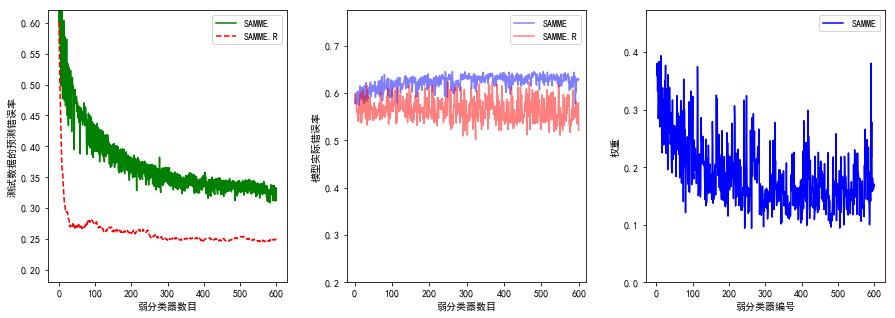

In [10]:
## 画图
plt.figure(figsize=(15,5), facecolor='w')

## 第一个子图（SAMME和SAMME.R的弱分类器和错误率关系）
plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),discrete_test_errors, c = 'g', label ='SAMME')
plt.plot(range(1, n_trees_real + 1), real_test_errors, c='r', linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('测试数据的预测错误率')
plt.xlabel('弱分类器数目')

## 第二个子图(AMME和SAMME.R的弱分类器和错误率关系)
plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors, 'b', label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors, 'r', label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('模型实际错误率')
plt.xlabel('弱分类器数目')
plt.ylim(.2, max(real_estimator_errors.max(), discrete_estimator_errors.max() * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

## 第三个子图(SAMME情况下，弱分类器数目和权重关系)
plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weghts, 'b', label='SAMME')
plt.legend()
plt.ylabel('权重')
plt.xlabel('弱分类器编号')
plt.ylim((0, discrete_estimator_weghts.max() * 1.2))

# 显示
plt.subplots_adjust(wspace=0.25)
plt.show()